In [1]:
#!pip3 install xgboost imblearn sklearn pickle pandas matplotlib seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from dateutil import parser
import os
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from data_preprocessing_v2 import Data_Preprocessing
from model_v2 import model_fit, model_blending, feature_importance
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
def validate_dirs(dir):
    try: 
        if not os.path.exists(dir):
            os.makedirs(dir)  
    except OSError:
        print('Error: Creating directory to store person')

In [3]:
validate_dirs("models")
validate_dirs("result")
validate_dirs("cm")

In [4]:
train_df = pd.read_csv('train/train.csv')
test_df= pd.read_csv('test/test.csv')

In [5]:
train_df.head(10)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,< 1 Year,Yes,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,< 1 Year,Yes,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,1-2 Year,Yes,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,< 1 Year,No,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,< 1 Year,No,28771.0,152.0,80,0


In [6]:
data_processor  = Data_Preprocessing()
train_drop_colums = ['Response','id']
test_drop_colums = ['id']
label_column = 'Response'
key = 'id'
custom_encode_col = "Vehicle_Age"
X, Y = data_processor.data_processing_pipeline(train_df, train_drop_colums , label_column, key, data_type = 'Train', custom_encode_col=custom_encode_col) 


X_test = data_processor.data_processing_pipeline(test_df, test_drop_colums , label_column, key, data_type = 'Test', custom_encode_col=custom_encode_col) 

Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')
 
## :: Train :: ##
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage

:: Pandas correlation : Categorical VS Numerical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
id,0.000999,-0.001345,-0.001507,1.000000
Age,0.145545,-0.522300,0.267534,0.001561
Driving_License,-0.018374,0.030173,-0.016622,-0.000564
Region_Code,0.000604,-0.027840,0.028235,-0.000572
Previously_Insured,-0.081932,0.174783,-0.824143,0.002457
Annual_Premium,0.003673,0.023656,0.009349,0.003027
Policy_Sales_Channel,-0.111159,0.388551,-0.224377,-0.002837
Vintage,-0.002517,0.002484,-0.002064,-0.000630
Response,0.052440,-0.104078,0.354400,-0.001368



:: Pandas correlation : Categorical VS Categorical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
Gender,1.000000,-0.112625,0.091606,0.000999
Vehicle_Age,-0.112625,1.000000,-0.174238,-0.001345
Vehicle_Damage,0.091606,-0.174238,1.000000,-0.001507
id,0.000999,-0.001345,-0.001507,1.000000


381109
Categorical_Columns ::  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object')
Numerical_Columns ::  Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')
 
## :: Test :: ##
CATEGORICAL COLUMN ENCODED ::  Gender
CATEGORICAL COLUMN ENCODED ::  Vehicle_Age
CATEGORICAL COLUMN ENCODED ::  Vehicle_Damage

:: Pandas correlation : Categorical VS Numerical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
id,0.000576,0.002350,0.000988,1.000000
Age,0.149650,-0.524189,0.270706,-0.005364
Driving_License,-0.015621,0.029533,-0.013101,-0.003581
Region_Code,0.000952,-0.026971,0.024151,-0.001574
Previously_Insured,-0.085088,0.177841,-0.823464,-0.000281
Annual_Premium,0.002968,0.023207,0.009968,0.001386
Policy_Sales_Channel,-0.112806,0.389822,-0.230298,0.002911
Vintage,-0.000842,0.000312,0.001879,0.001225



:: Pandas correlation : Categorical VS Categorical :: 


,Gender,Vehicle_Age,Vehicle_Damage,id
Gender,1.000000,-0.115935,0.094250,0.000576
Vehicle_Age,-0.115935,1.000000,-0.177244,0.002350
Vehicle_Damage,0.094250,-0.177244,1.000000,0.000988
id,0.000576,0.002350,0.000988,1.000000


127037


In [7]:
X.head()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Age,Vehicle_Damage
0,44,1,28.0,0,40454.0,26.0,217,1,2,1
1,76,1,3.0,0,33536.0,26.0,183,1,0,0
2,47,1,28.0,0,38294.0,26.0,27,1,2,1
3,21,1,11.0,1,28619.0,152.0,203,1,1,0
4,29,1,41.0,1,27496.0,152.0,39,0,1,0


# XGBoost and CatBoost
* `KFold`
* `StratifiedShuffleSplit`


In [8]:
def save_result(result, file_name):
    df_sub = pd.read_csv('sample_submission.csv')
    df_sub.head()
    df_xgb = df_sub.copy()
    df_xgb['Response'] = result
    df_xgb.head()
    df_xgb.to_csv('result/'+ filename +'.csv', index=False )

In [9]:
%%capture
# model---> xgboost 
split_type = "stratifiedsuffleSplit" # stratifiedsuffleSplit, stratifiedKFold, kfold
model_name = "xgboost"
probs_xgb, probs_xgb_train, model = model_fit(X, Y, X_test, 5, split_type, model_name)

[0.00912362 0.00185309 0.00323935 0.5759442  0.00197596 0.011295
 0.00124753 0.0016831  0.0181315  0.3755066 ]


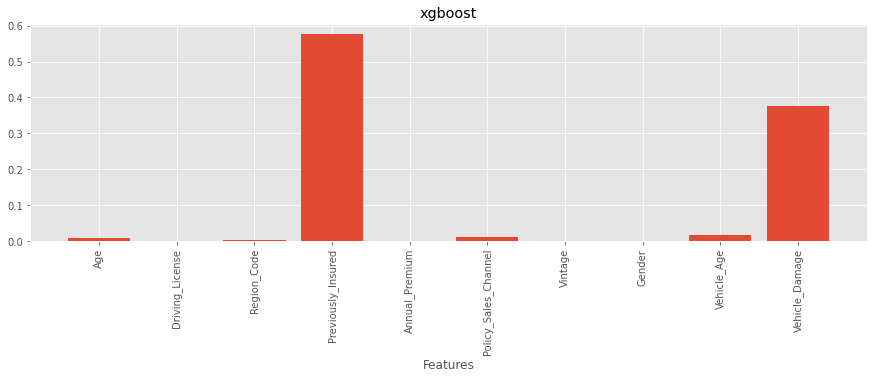

In [10]:
# Feature Importance 
plt.subplots(figsize=(15, 4))
feature_importance(model, X, model_name)

In [11]:
%%capture
# model---> catboost 
split_type = "stratifiedsuffleSplit" # stratifiedsuffleSplit, stratifiedKFold
model_name = "catboost"
probs_cb, probs_cb_train, model = model_fit(X, Y, X_test, 5, split_type, model_name )

[11.74401911  0.07870499  8.92832467 44.53736221  4.93055906  9.24529416
  3.42795647  2.11910277  2.89352468 12.09515188]


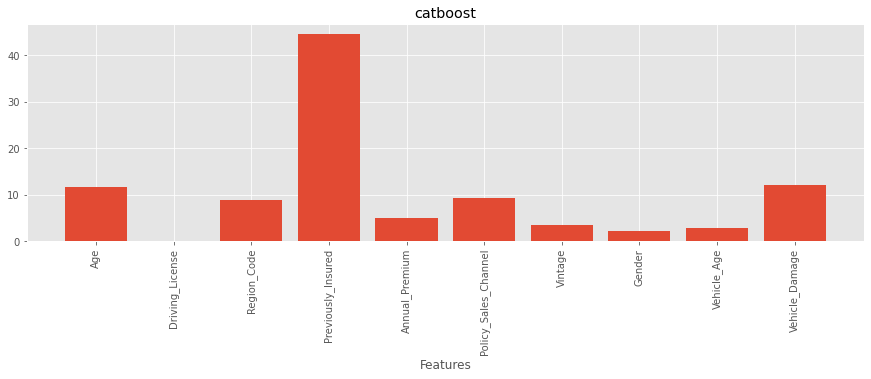

In [12]:
# Feature Importance
fig, ax = plt.subplots(figsize=(15, 4))
feature_importance(model, X, model_name)

In [13]:
# Test set predict_probs
p_cb = probs_cb/5
p_xgb = probs_xgb/5 
# Train Set Predict_probs 
p_cb_train = probs_cb_train/5
p_xgb_train = probs_xgb_train/5 

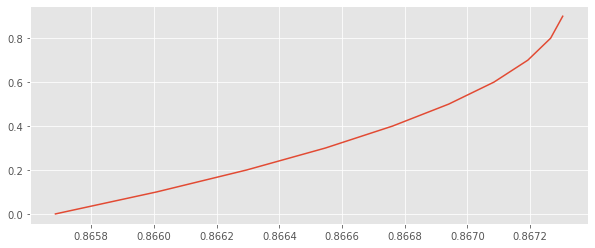

0.9

0.8673039397093734

In [14]:
from model_v2 import model_blending as blend
from sklearn.metrics import roc_auc_score,confusion_matrix
plt.subplots(figsize=(10, 4))
best_w, best_roc = blend(p_xgb_train, p_cb_train, Y)
display(best_w)
display(best_roc)

In [15]:
w = best_w
result = w * p_xgb + (1-w) *p_cb
filename = "model_blending_cb_xgb_"+split_type+"_best_w-" + str(w) + "-"+ datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
save_result(result, filename)

In [16]:
w = 0.5
result = w * p_xgb + (1-w) *p_cb
filename = "model_blending_cb_xgb_"+split_type+"_best_w-" + str(w) + "-"+ datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
save_result(result, filename)

# Model Load and Predict, predict_proba

In [17]:
def model_predict(X,model_prefix, prediction=None, predict_probs=None):  
    import pickle, joblib
    import glob
    pridict = np.zeros(shape=(len(X),))
    models_path = glob.glob(model_prefix)
    for i, v in enumerate(models_path):
        print(i)
        model = joblib.load(v)
        if prediction:
            result = model.predict(X)
        if predict_probs:
            result = model.predict_proba(X)    
        pridict += result
    return pridict    


# Confusion Matrix

In [19]:
# Xgboost 
y_pred_xgb = (model_predict(X, "models/xgboost_"+ split_type + "*", prediction=True, predict_probs=False)/5).astype(int)
cm_xgb = confusion_matrix(Y, y_pred_xgb)
cm_df_xgb = pd.DataFrame(data=cm_xgb, columns=["Response_0", "Response_1"], index=["Response_0", "Response_1"])
cm_df_xgb.to_csv("cm/xgb_cm_" + split_type + ".csv")
#catboost
y_pred_cb = (model_predict(X, "models/catboost_" + split_type + "*", prediction=True, predict_probs=False)/5).astype(int)
cm_cb = confusion_matrix(Y, y_pred_cb)
cm_df_cb = pd.DataFrame(data=cm_cb, columns=["Response_0", "Response_1"], index=["Response_0", "Response_1"])
cm_df_cb.to_csv("cm/catboost_cm_" + split_type + ".csv")

0
1
2
3
4
0
1
2
3
4
